Processing LDA for patient 1
Test accuracy for patient 1: 0.4984


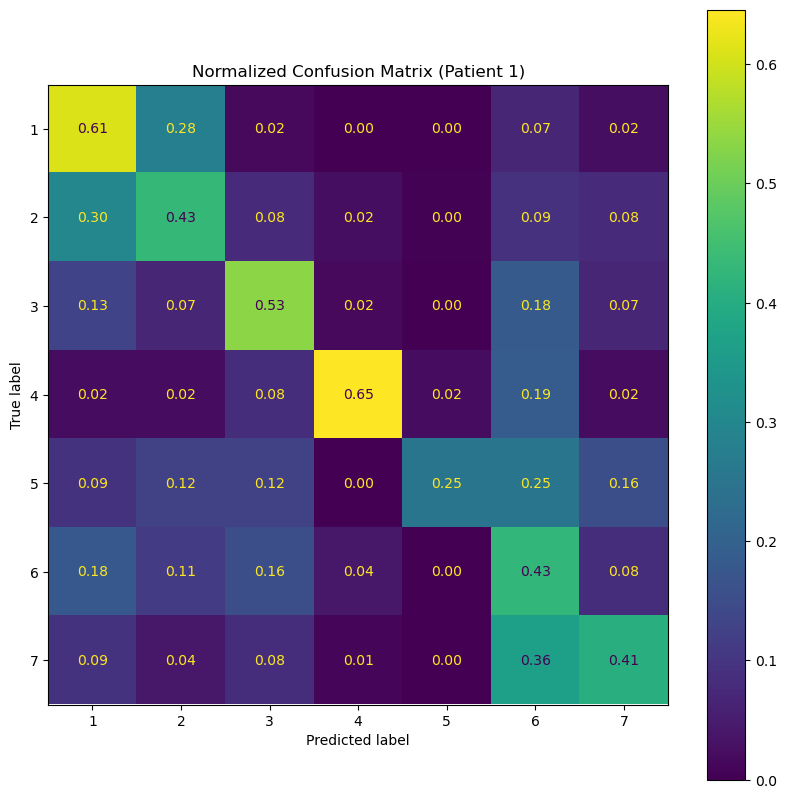

Processing LDA for patient 2
Test accuracy for patient 2: 0.6574


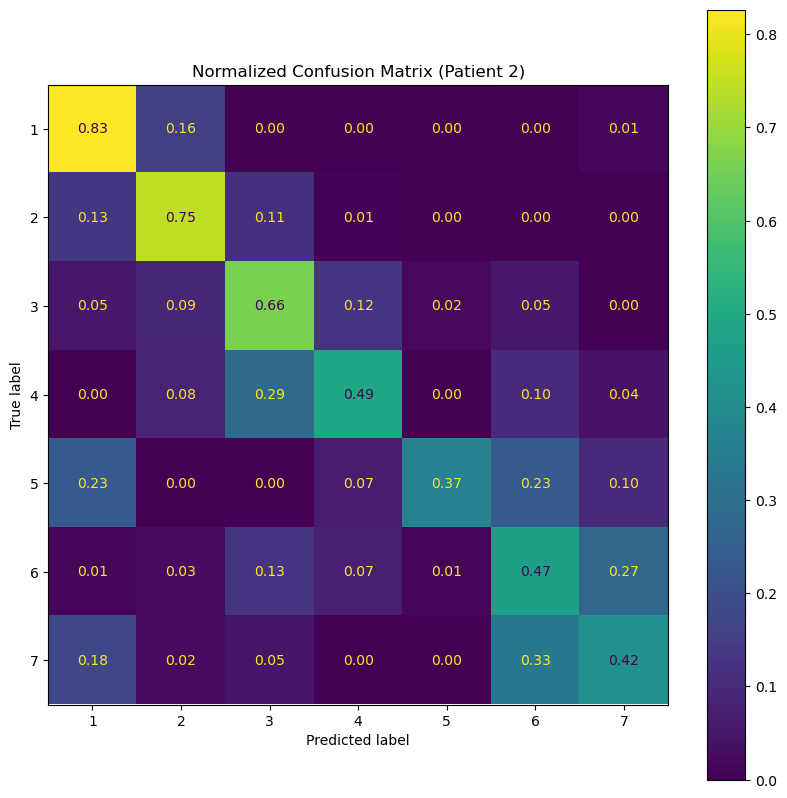

Processing LDA for patient 3
Test accuracy for patient 3: 0.4591


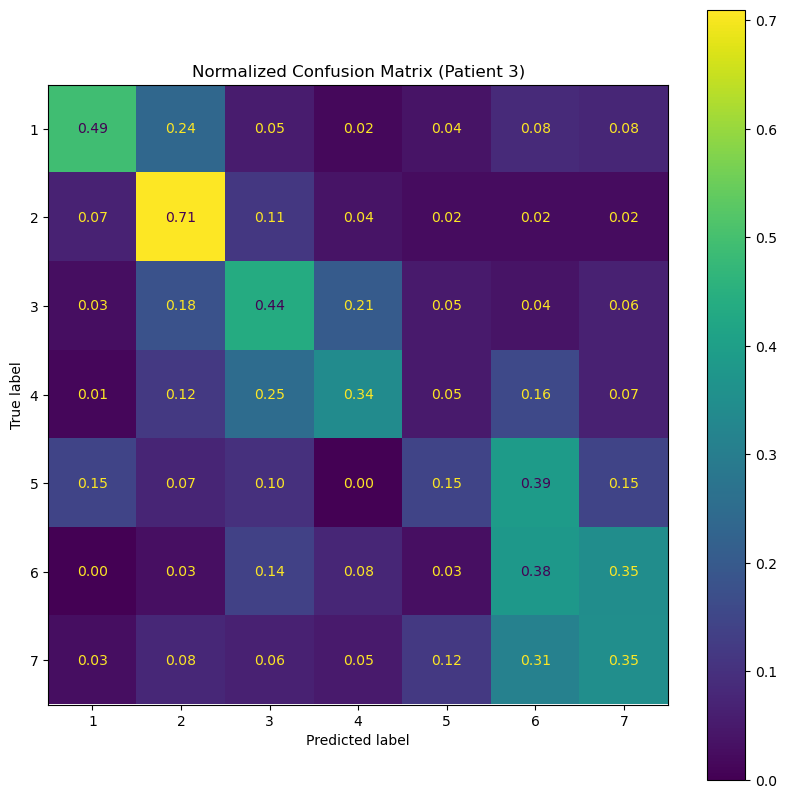

Processing LDA for patient 4
Test accuracy for patient 4: 0.4639


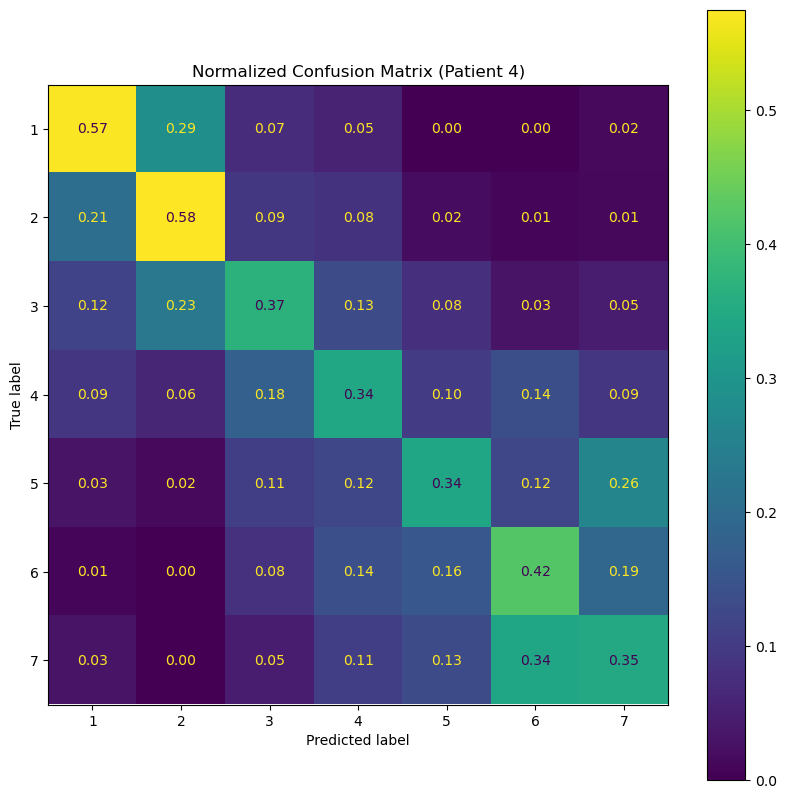

Processing LDA for patient 5
Test accuracy for patient 5: 0.4879


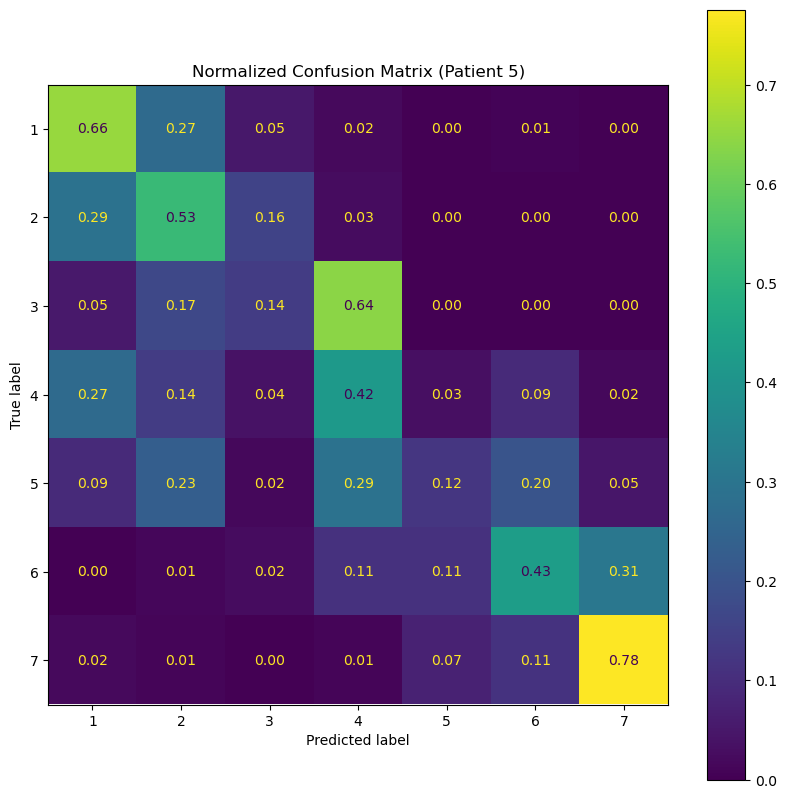

Processing LDA for patient 6
Test accuracy for patient 6: 0.5246


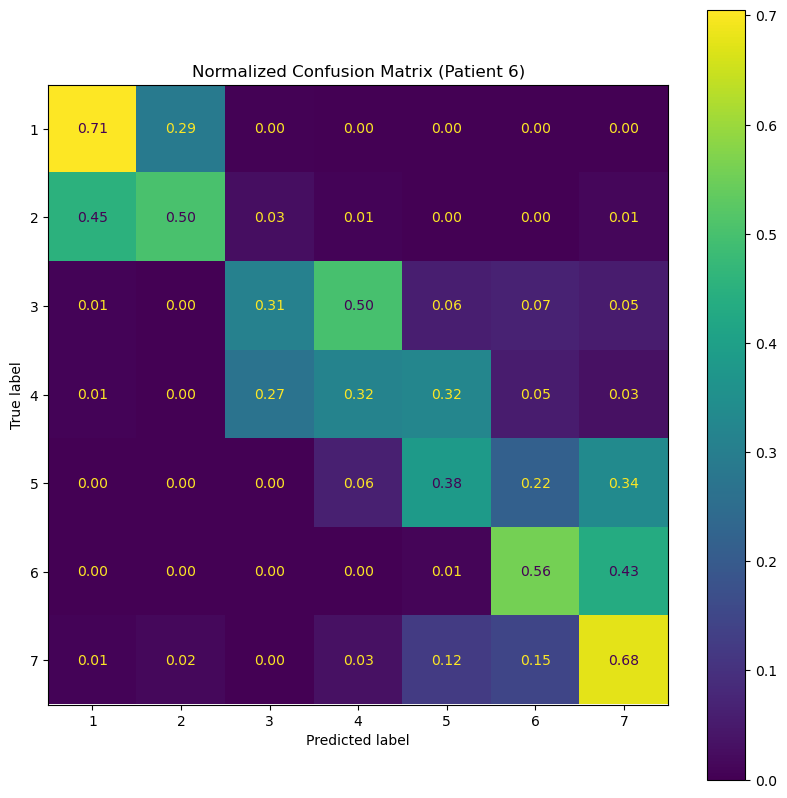

Processing LDA for patient 7
Test accuracy for patient 7: 0.2488


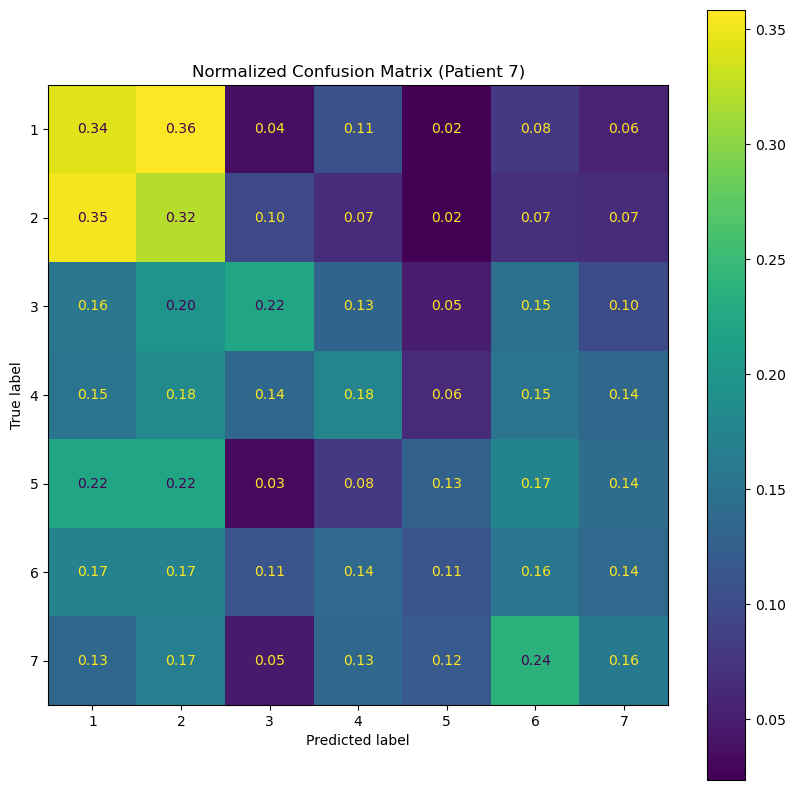

Processing LDA for patient 8
Test accuracy for patient 8: 0.6094


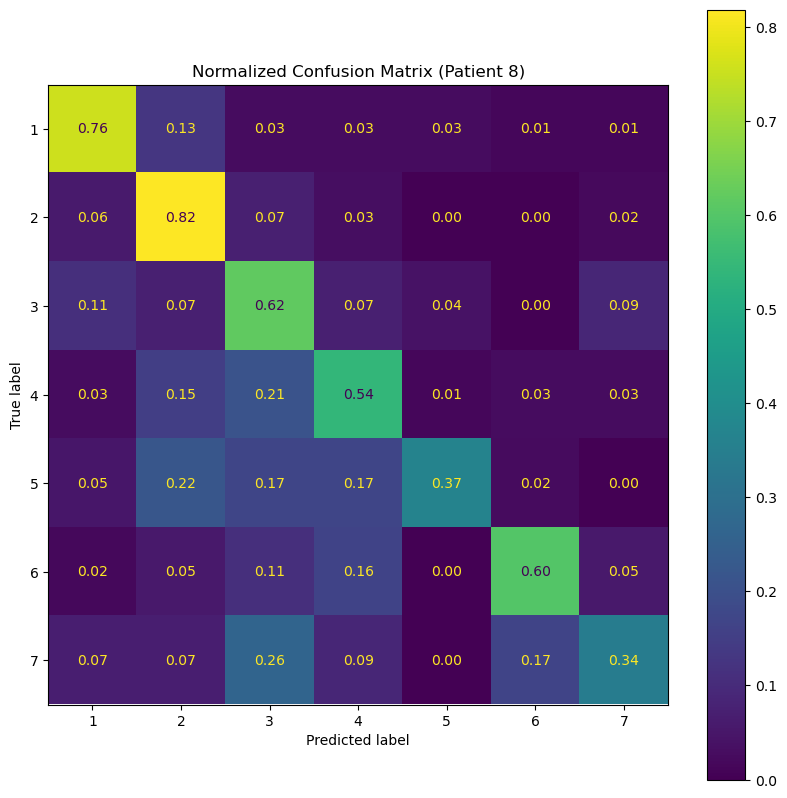

Processing LDA for patient 9
Test accuracy for patient 9: 0.5956


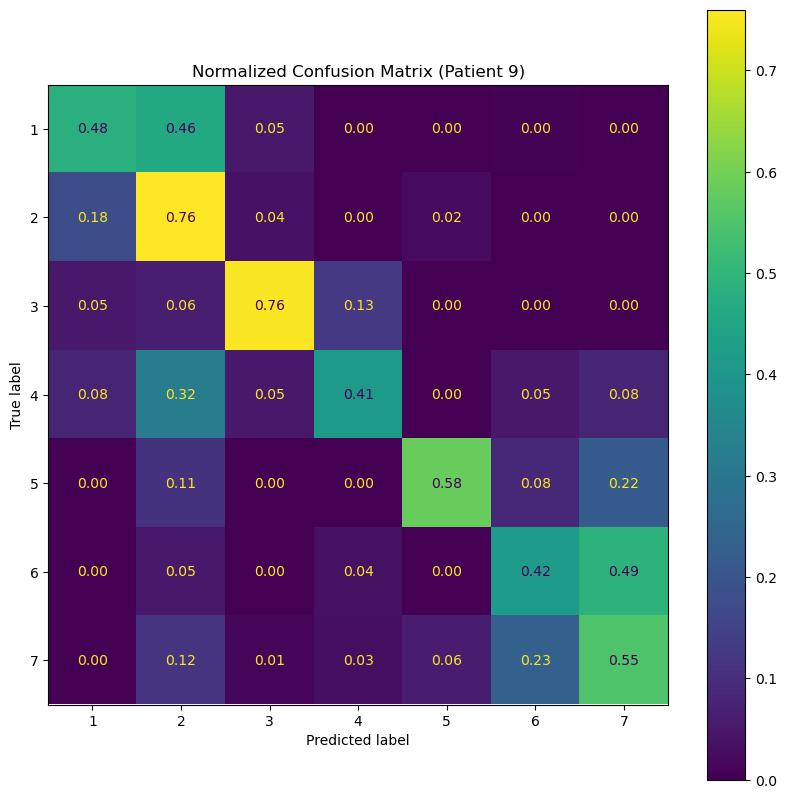

Processing LDA for patient 10
Test accuracy for patient 10: 0.4194


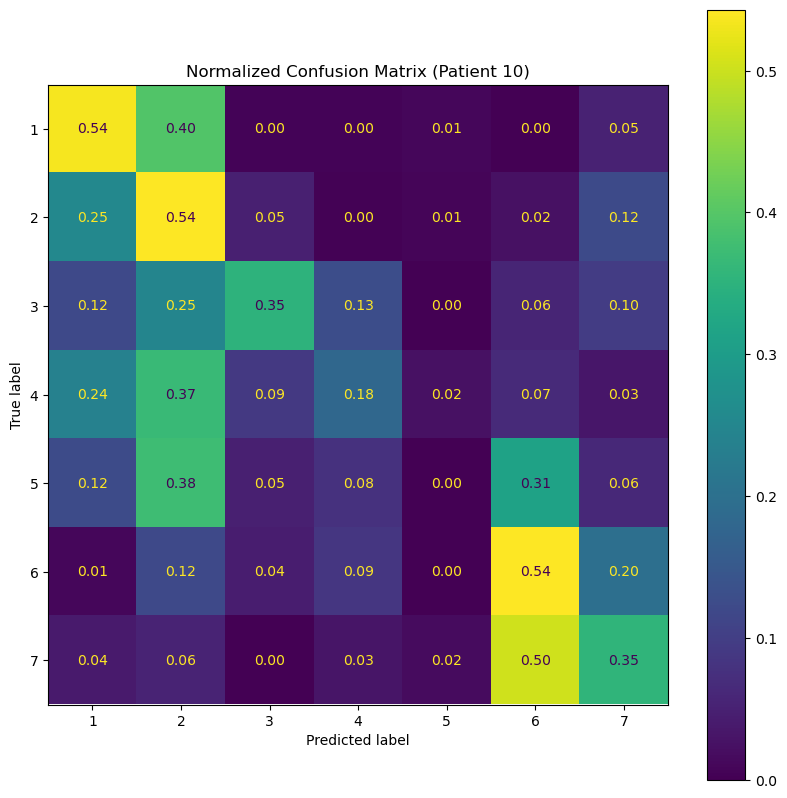

Processing LDA for patient 11
Test accuracy for patient 11: 0.5623


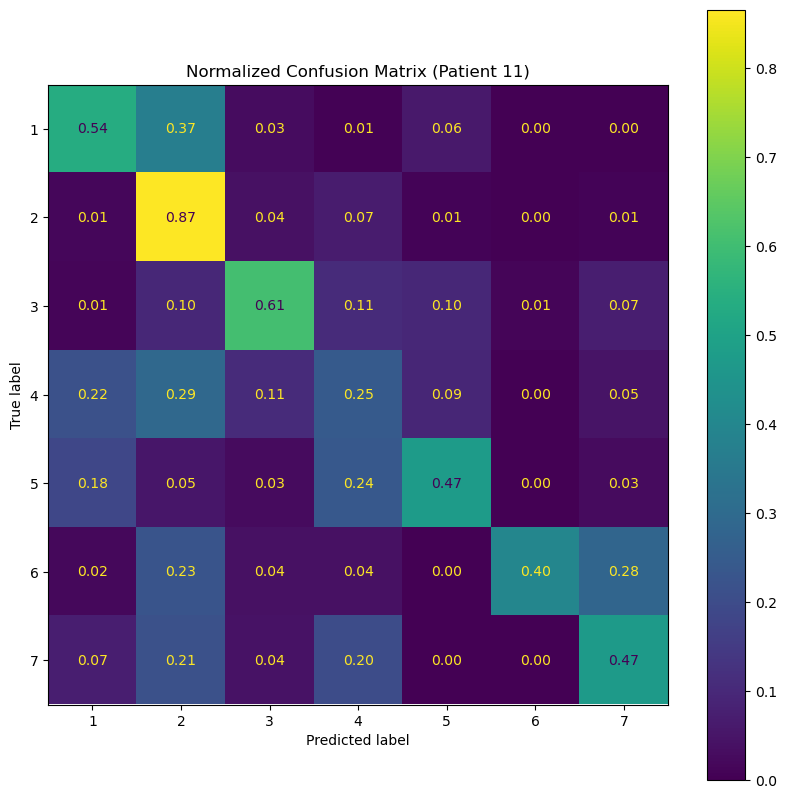

File not found for patient 12: /Users/aidantang/Desktop/Gesture_recog/Feature_extract_dataV2/S12_features_regrouped.csv


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import os
import plotly.graph_objects as go
from scipy.interpolate import griddata

# Data folder
data_folder = '/Users/aidantang/Desktop/Gesture_recog/Feature_extract_dataV2'

# Store results for plotting
results = []

# List of patient IDs
patient_ids = range(1, 13)

# Iterate over all patients
for patient_id in patient_ids:
    file_path = os.path.join(data_folder, f'S{patient_id}_features_regrouped.csv')
    if not os.path.exists(file_path):
        print(f"File not found for patient {patient_id}: {file_path}")
        continue
    print(f"Processing LDA for patient {patient_id}")
    
    # Load the data
    data = pd.read_csv(file_path)
    data = data[data['Stimulus'] != 0]  # Drop rest state
    data = data.fillna(0)
    
    # Split data into train, validation, and test sets
    train_data = data[data['Repetition'].isin([1, 2, 3])]
    val_data = data[data['Repetition'].isin([4, 5])]
    test_data = data[data['Repetition'].isin([6])]
    
    # Select feature columns
    feature_cols = [col for col in data.columns if col not in ['Stimulus', 'Repetition', 'Years_Since_Amputation', 'Forearm_Percentage','Myoelectric_Use']]
    X_train, y_train = train_data[feature_cols], train_data['Stimulus']
    X_val, y_val = val_data[feature_cols], val_data['Stimulus']
    X_test, y_test = test_data[feature_cols], test_data['Stimulus']
    
    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    # Train LDA model
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)
    
    # Compute accuracy
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Test accuracy for patient {patient_id}: {test_accuracy:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    unique_labels = sorted(y_test.unique())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(cmap='viridis', values_format=".2f", ax=ax)
    plt.title(f'Normalized Confusion Matrix (Patient {patient_id})')
    plt.show()
    
    # Extract metadata
    forearm_col_name = [col for col in data.columns if "Forearm_Percentage" in col][0]
    years_col_name = [col for col in data.columns if "Years_Since_Amputation" in col][0]
    myo_col_name = [col for col in data.columns if "Myoelectric_Use" in col][0]

    ForearmPercentage = data[forearm_col_name].unique()[0]
    YearsSinceAmputation = data[years_col_name].unique()[0]
    MyoelectricUse = data[myo_col_name].unique()[0]
    
    # Store results
    results.append({
        'PatientID': patient_id,
        'Model' : LDA,
        'TestAccuracy': test_accuracy,
        'ForearmPercentage': ForearmPercentage,
        'YearsSinceAmputation': YearsSinceAmputation,
        'MyoelectricUse': MyoelectricUse,
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)


In [20]:
import scipy.stats as stats
import statsmodels.api as sm
#save into compare file
df_results.to_csv('results_comparison.csv', index=False)
# Statistical analysis function
def analyze_relationship(x, y, variable_name):
    # Pearson correlation
    r, p_value_corr = stats.pearsonr(x, y)
    
    # Linear Regression Analysis
    X = sm.add_constant(x)  # Add constant for intercept
    model = sm.OLS(y, X).fit()
    p_value_reg = model.pvalues[1]  # p-value for the predictor variable
    
    print(f"\nAnalysis for {variable_name}:")
    print(f"Pearson Correlation: r = {r:.4f}, p-value = {p_value_corr:.4f}")
    print(f"Linear Regression: Coefficient = {model.params[1]:.4f}, p-value = {p_value_reg:.4f}")
    
    if p_value_corr < 0.05:
        print(f"→ The correlation between {variable_name} and Accuracy is statistically significant (p < 0.05).")
    else:
        print(f"→ No significant correlation found (p >= 0.05).")
    
    if p_value_reg < 0.05:
        print(f"→ The regression model suggests a significant effect of {variable_name} on Accuracy (p < 0.05).")
    else:
        print(f"→ No significant effect found in regression (p >= 0.05).")

# Perform analysis
analyze_relationship(results_df['YearsSinceAmputation'], results_df['TestAccuracy'], "Years Since Amputation")
analyze_relationship(results_df['ForearmPercentage'], results_df['TestAccuracy'], "Forearm Percentage")
analyze_relationship(results_df['MyoelectricUse'], results_df['TestAccuracy'], "Myoelectric Use")

# 2D Scatter Plots with Regression Lines
plt.figure(figsize=(10, 6))
plt.scatter(results_df['YearsSinceAmputation'], results_df['TestAccuracy'], c='blue', label='Accuracy')
coeffs = np.polyfit(results_df['YearsSinceAmputation'], results_df['TestAccuracy'], deg=1)
plt.plot(results_df['YearsSinceAmputation'], np.polyval(coeffs, results_df['YearsSinceAmputation']), color='blue', label='Best Fit Line')
plt.xlabel('Years Since Amputation')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Years Since Amputation')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(results_df['ForearmPercentage'], results_df['TestAccuracy'], c='green', label='Accuracy')
coeffs = np.polyfit(results_df['ForearmPercentage'], results_df['TestAccuracy'], deg=1)
plt.plot(results_df['ForearmPercentage'], np.polyval(coeffs, results_df['ForearmPercentage']), color='green', label='Best Fit Line')
plt.xlabel('Forearm Percentage')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Forearm Percentage')
plt.legend()
plt.grid()
plt.show()

# 2D Scatter Plots with Regression Lines
plt.figure(figsize=(10, 6))
plt.scatter(results_df['MyoelectricUse'], results_df['TestAccuracy'], c='red', label='Accuracy')
coeffs = np.polyfit(results_df['MyoelectricUse'], results_df['TestAccuracy'], deg=1)
plt.plot(results_df['MyoelectricUse'], np.polyval(coeffs, results_df['MyoelectricUse']), color='red', label='Best Fit Line')
plt.xlabel('Myoelectric Use')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Myoelectric Use')
plt.legend()
plt.grid()
plt.show()



NameError: name 'df_results' is not defined

In [16]:
# 3D Surface Plot for Accuracy vs Years Since Amputation & Forearm Percentage
x = results_df['ForearmPercentage']
y = results_df['YearsSinceAmputation']
z = results_df['TestAccuracy']

# Create a grid
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
xi, yi = np.meshgrid(xi, yi)
zi = griddata((x, y), z, (xi, yi), method='linear')

fig = go.Figure(data=[go.Surface(
    x=xi, y=yi, z=zi, colorscale='Viridis',
    contours=dict(z=dict(show=True, usecolormap=True, project_z=True))
)])

# Labels
fig.update_layout(
    title='LDA: Test Accuracy vs. Years Since Amputation and Forearm Percentage',
    scene=dict(
        xaxis_title='Forearm Percentage',
        yaxis_title='Years Since Amputation',
        zaxis_title='Test Accuracy',
    ),
    width=800,
    height=700
)

fig.show()
